In [1]:
import torchvision
from torchvision import datasets, models, transforms
import torch.utils.data as utils
from torch.utils.data import DataLoader,Dataset
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import time
import copy
# from torch.nn import TripletMarginLoss
from torch.optim import lr_scheduler
import os
from PIL import Image, ImageEnhance
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pandas as pd 
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score
import PIL.ImageOps    

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    train_batch_size = 1
    train_number_epochs = 8

In [4]:
training_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/train"
testing_dir = "/home/care1e55/study/DBO/project/gpds/combined/combined/test"
training_csv="/home/care1e55/study/DBO/project/gpds/train_hard_triplet_data.csv"
testing_csv="/home/care1e55/study/DBO/project/gpds/test_hard_triplet_data.csv"


In [5]:
training_dir = "/home/care1e55/study/DBO/project/sign_data/train"
testing_dir = "/home/care1e55/study/DBO/project/sign_data/test"
training_csv="/home/care1e55/study/DBO/project/clean/signet_random_triplet_train.csv"
testing_csv="/home/care1e55/study/DBO/project/clean/signet_random_triplet_test.csv"


In [6]:
RESCALE_SIZE = 224
DATA_MODES = ['train', 'vis', 'test']

In [7]:
pd.read_csv(training_csv).head(2)

sample
0  002_forg/0118002_02.png
1  002_forg/0108002_02.png

In [8]:
class HardTripletDataset():
    def __init__(self, base_path, transform=None):
        self.transform = transform
        self.genuie = []
        self.forged = []
        # self.base_path = './gpds/combined/combined'
        self.base_path = base_path
        self.dataframes = []
        files_list = []

        for root, dirs, files in tqdm(os.walk(self.base_path)):
            if files:
                self.dataframes.append([os.path.join(root.split("/")[-1], file) for file in files ])

        dataframes = self.dataframes
        for i in tqdm(range(len(dataframes))):
            if '_forg' not in dataframes[i][0]:
                cur_genuie = dataframes[i]
                for j, dataframe in enumerate(dataframes):
                    if dataframes[i][0].split("/")[0]+"_forg" == dataframes[j][0].split("/")[0]:
                        cur_forg = dataframes[j]
                        break 
                self.genuie.append(cur_genuie)
                self.forged.append(cur_forg)

    def __len__(self):
        return int(len(self.dataframes)//2)
    
    def __getitem__(self, index):
        cur_genuie = self.genuie[index]
        cur_forged = self.forged[index]
        cur_genuie_batch = self.prepare_batch(cur_genuie)
        cur_forged_batch = self.prepare_batch(cur_forged)
        return cur_genuie_batch, cur_forged_batch
    

    def prepare_batch(self, batch):
        for n, i in enumerate(batch):
            cur_img = Image.open(os.path.join(self.base_path,i)).convert('L')
            cur_img = PIL.ImageOps.invert(cur_img)
            cur_img = cur_img.convert('RGB')
            cur_img.load()
            if self.transform is not None:
                cur_img = self.transform(cur_img)
            if n == 0:
                prepared_batch = cur_img.unsqueeze(0)
            else:
                prepared_batch = torch.cat((prepared_batch, cur_img.unsqueeze(0)), 0)            
        return prepared_batch

    
    def prepare_one(self, one):
        cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
        cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    

In [9]:
transform = transforms.Compose([
    transforms.RandomRotation(degrees = 10, fill=0),
    transforms.RandomAffine(degrees=(-10, 10), translate=None, scale=None, shear=(-10,10), resample=False, fillcolor=(0,0,0)),
    
    transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
    transforms.ToTensor(),
        ])

In [10]:
def set_parameter_requires_grad(model):
    for param in model.parameters():
        param.requires_grad = True

In [11]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        self.resnet = models.resnet18(pretrained=False)
        set_parameter_requires_grad(self.resnet)
        # self.resnet.avgpool = AdaptiveMaxPool2d(output_size=(1, 1))
        self.resnet.avgpool = torch.nn.AdaptiveMaxPool2d(output_size=(1, 1))
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
                nn.Linear(num_ftrs, 1024),
                nn.ReLU(inplace=True),
                nn.Linear(1024, 128),
            )
        
    def forward_once(self, x):
        output = self.resnet(x)
        return output

    # def forward_batch(self, input1, input2):
    #     for i in input1:

    def forward(self, input1, input2):
        pos_features = self.forward_once(input1)
        neg_features = self.forward_once(input2)
        # print(pos_features.size())
        # print(neg_features.size())
        idx = torch.randperm(pos_features.size(0))[0]
        anchor = pos_features[idx]
        # print(anchor.size())
        pos_idx = torch.argmax(torch.cdist(pos_features, anchor.unsqueeze(0), p=2.0))
        neg_idx = torch.argmin(torch.cdist(neg_features, anchor.unsqueeze(0), p=2.0))

        # print(anchor.size(), pos_features[pos_idx].size(), neg_features[neg_idx].size())
        return anchor.unsqueeze(0), pos_features[pos_idx].unsqueeze(0), neg_features[neg_idx].unsqueeze(0)

    def inference(self, x):
        with torch.no_grad():
            output = self.resnet(x)
            return output

In [12]:
net = SiameseNetwork().cuda()

In [13]:
train_datasdet = HardTripletDataset(training_dir, transform=transform)

87it [00:00, 19303.03it/s]
100%|██████████| 86/86 [00:00<00:00, 59888.78it/s]


In [14]:
vis_dataloader = DataLoader(train_datasdet, shuffle=True, batch_size=1)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
example_batch[0].size()

torch.Size([1, 12, 3, 224, 224])

In [15]:
vis_dataloader = DataLoader(train_datasdet, shuffle=True, batch_size=1)
dataiter = iter(vis_dataloader)
example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0], example_batch[1], example_batch[2]),0)
imshow(torchvision.utils.make_grid(concatenated))

IndexError: list index out of range

In [15]:
print(net)

SiameseNetwork(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

In [16]:
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = (anchor - positive).pow(2).sum(1)  # .pow(.5)
        distance_negative = (anchor - negative).pow(2).sum(1)  # .pow(.5)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        return losses.mean() if size_average else losses.sum()

In [17]:
if torch.cuda.is_available():
    print('Yes')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Yes


In [18]:
def fit_epoch(net, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_loader,0), total = len(train_loader)):
        img0, img1, img2 = data
        img0, img1, img2 = img0.cuda(), img1.cuda() , img2.cuda()
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1, img2)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [19]:
def fit_epoch(net, train_files, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    log_template = "\nIteration {ep:03d} train_loss: {t_loss:0.4f}"  
    
    for i, data in tqdm(enumerate(train_files,0), total = len(train_files)):
        img0, img1 = data
        img0, img1 = img0.cuda(), img1.cuda()
        # print(img0.size())
        optimizer.zero_grad()
        output1, output2, output3 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, output3)
        loss_contrastive.backward()
        optimizer.step()
        running_loss += loss_contrastive.item() * data[0].size(0)
        processed_data += data[0].size(0)
          
    train_loss = running_loss / processed_data

    return train_loss

In [23]:
def train(train_files, net, epochs, batch_size):
    # train_dataloader = DataLoader(train_files,
    #                     shuffle=True,
    #                     num_workers=4,
    #                     batch_size=batch_size)

    history = []
   
    opt = optim.AdamW(net.parameters(), lr=0.05)
    # scheduler = StepLR(opt, step_size=1, gamma=0.5)
    scheduler = StepLR(opt, step_size=5, gamma=0.9)
    criterion = TripletLoss()
    # criterion = nn.TripletMarginLoss(margin = 1.0)

    for epoch in range(epochs):
        print("Epoch:", epoch)
        # train_loss = fit_epoch(net, train_dataloader, criterion, opt)
        train_loss = fit_epoch(net, train_files, criterion, opt)
        print("loss:", train_loss)
        
        scheduler.step()
        history.append((train_loss))
                 
    return history

In [24]:
# history = train(train_datasdet, net=net, epochs=Config.train_number_epochs, batch_size=Config.train_batch_size)
history = train(train_datasdet, net=net, epochs=50, batch_size=12)

  0%|          | 0/43 [00:00<?, ?it/s]loss: 77872.56931729054
Epoch: 1
  0%|          | 0/43 [00:00<?, ?it/s]loss: 2867.4200226070375
Epoch: 2
  0%|          | 0/43 [00:00<?, ?it/s]loss: 414.18239246278296
Epoch: 3
  0%|          | 0/43 [00:00<?, ?it/s]loss: 151.53217256801335
Epoch: 4
  0%|          | 0/43 [00:00<?, ?it/s]loss: 133.0387116800143
Epoch: 5
  0%|          | 0/43 [00:00<?, ?it/s]loss: 39.156283932783474
Epoch: 6
  0%|          | 0/43 [00:00<?, ?it/s]loss: 14.495735704617237
Epoch: 7
  0%|          | 0/43 [00:00<?, ?it/s]loss: 9.661005984328863
Epoch: 8
  0%|          | 0/43 [00:00<?, ?it/s]loss: 6.743395161065529
Epoch: 9
  0%|          | 0/43 [00:00<?, ?it/s]loss: 5.388555170795111
Epoch: 10
  0%|          | 0/43 [00:00<?, ?it/s]loss: 4.810083452359898
Epoch: 11
  0%|          | 0/43 [00:00<?, ?it/s]loss: 3.431264438779335
Epoch: 12
  0%|          | 0/43 [00:00<?, ?it/s]loss: 3.2583862424835446
Epoch: 13
  0%|          | 0/43 [00:00<?, ?it/s]loss: 2.70239890654256
Epoch:

In [ ]:
torch.save(net.state_dict(), "model_random_sampling_clean.pt")
print("Model Saved Successfully")

In [ ]:
net.load_state_dict(torch.load("model_random_sampling_clean.pt"))

In [25]:
transform = transforms.Compose([
              transforms.Resize((RESCALE_SIZE,RESCALE_SIZE)),
              transforms.ToTensor(),
  ])

In [26]:
class TestDataset():
    
    def __init__(self,training_csv=None,base_path=None,transform=None):
        # used to prepare the labels and images path
        self.training_df=pd.read_csv(training_csv)
        self.training_df.columns =["image1","image2","label"]
        self.base_path = base_path    
        self.transform = transform

    def __getitem__(self,index):
        
        img0 = self.prepare_one(self.training_df.iat[index,0])
        img1 = self.prepare_one(self.training_df.iat[index,1])
            
        return img0, img1 , torch.from_numpy(np.array([int(self.training_df.iat[index,2])],dtype=np.float32))

    def prepare_one(self, one):
        cur_img = Image.open(os.path.join(self.base_path,one)).convert('L')
        cur_img = PIL.ImageOps.invert(cur_img)
        cur_img = cur_img.convert('RGB')
        cur_img.load()
        if self.transform is not None:
            cur_img = self.transform(cur_img)
        return cur_img
    
    def __len__(self):
        return len(self.training_df)

In [23]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/sign_data/test_data.csv", "/home/care1e55/study/DBO/project/sign_data/test/", transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

In [24]:
# test_dataset = TestDataset("/home/care1e55/study/DBO/project/sign_data/train_data.csv", "/home/care1e55/study/DBO/project/sign_data/train/", transform=transform)
# test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

In [27]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_sign_constrative_data.csv", testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

In [29]:
for t in np.arange(0.1,1.5,0.1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([t]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1 , label = data
        output1 = net.inference(x0.to(device))
        output2 = net.inference(x1.to(device))
        eucledian_distance = F.pairwise_distance(output1, output2)
        if label==list_0:
            targets.append(0)
        else:
            targets.append(1)
        
        if eucledian_distance <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{t} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{t} f1:", f1_score(n_targets, n_predictions, average='weighted'))

  0%|          | 0/5747 [00:00<?, ?it/s]0.1 acc: 0.518357403862885
0.1 f1: 0.3546918442566096
  0%|          | 0/5747 [00:00<?, ?it/s]0.2 acc: 0.5355837828432225
0.2 f1: 0.40483717337576963
  0%|          | 0/5747 [00:00<?, ?it/s]0.30000000000000004 acc: 0.5719505829128241
0.30000000000000004 f1: 0.50229805440972
  0%|          | 0/5747 [00:00<?, ?it/s]0.4 acc: 0.5858708891595615
0.4 f1: 0.5577641610226749
  0%|          | 0/5747 [00:00<?, ?it/s]0.5 acc: 0.594223072907604
0.5 f1: 0.5871417469517491
  0%|          | 0/5747 [00:00<?, ?it/s]0.6 acc: 0.5888289542369932
0.6 f1: 0.5887823260398198
  0%|          | 0/5747 [00:00<?, ?it/s]0.7000000000000001 acc: 0.5917870193144249
0.7000000000000001 f1: 0.5899268328737914
  0%|          | 0/5747 [00:00<?, ?it/s]0.8 acc: 0.5883069427527405
0.8 f1: 0.5800806231666019
  0%|          | 0/5747 [00:00<?, ?it/s]0.9 acc: 0.5823908125978772
0.9 f1: 0.563015938767998
  0%|          | 0/5747 [00:00<?, ?it/s]1.0 acc: 0.5757786671306768
1.0 f1: 0.543760291

KeyboardInterrupt: 

In [218]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.627805811727858

In [219]:
f1_score(n_targets, n_predictions, average='weighted')

0.5799401125640055

In [81]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.7847206888937956

In [82]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
n_false_predictions.astype('int').sum()/n_false_targets.astype('int').sum()

1.1999682590065068

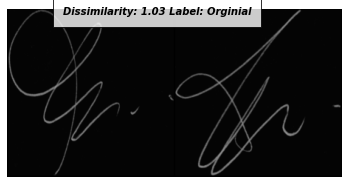

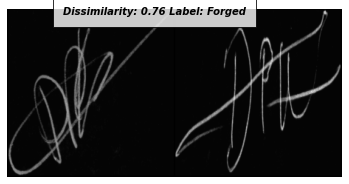

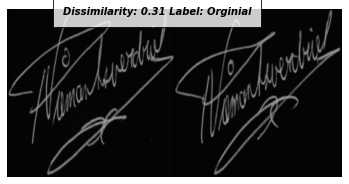

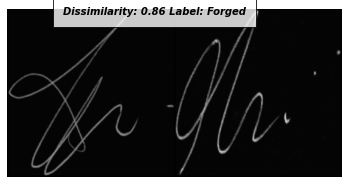

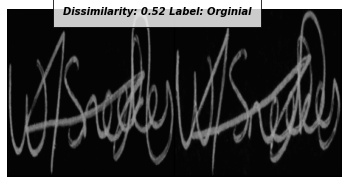

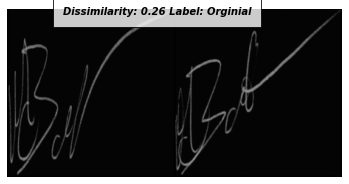

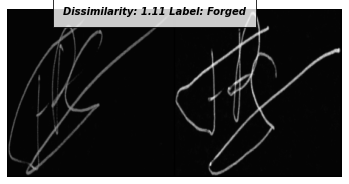

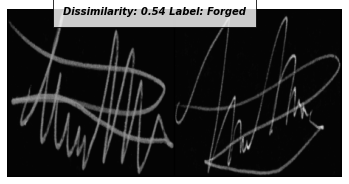

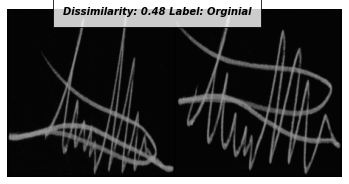

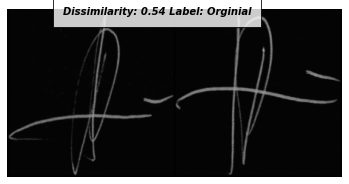

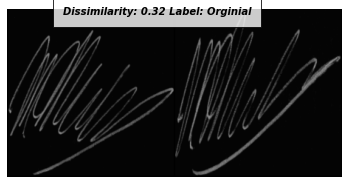

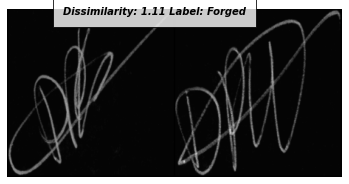

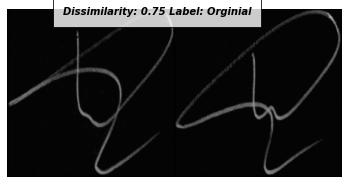

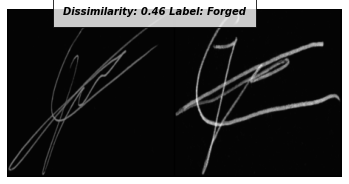

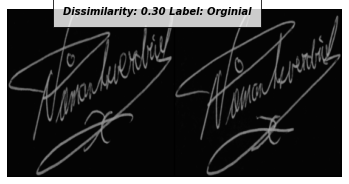

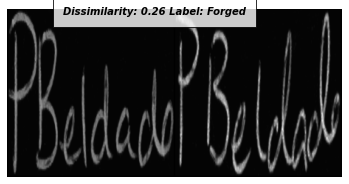

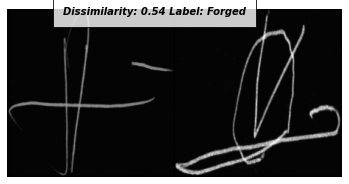

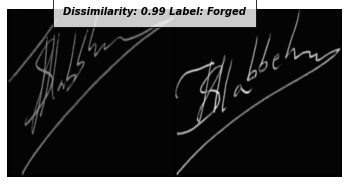

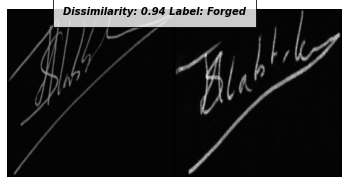

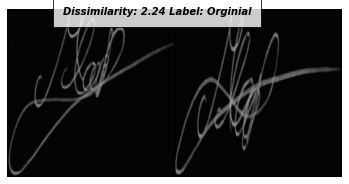

In [28]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 , label = data
  concatenated = torch.cat((x0,x1),0)
  output1 = net.inference(x0.to(device))
  output2 = net.inference(x1.to(device))
  eucledian_distance = F.pairwise_distance(output1, output2)
  if label==list_0:
    label="Orginial"
  else:
    label="Forged"
  imshow(torchvision.utils.make_grid(concatenated),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance.item(),label))
  counter=counter+1
  if counter ==20:
     break

In [26]:
test_dataset = HardTripletDataset(testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

43it [00:00, 3014.86it/s]
100%|██████████| 42/42 [00:00<00:00, 86100.08it/s]


In [30]:
test_dataset = TestDataset("/home/care1e55/study/DBO/project/clean/test_sign_constrative_data.csv", testing_dir, transform=transform)
test_dataloader = DataLoader(test_dataset, num_workers=6, batch_size=1, shuffle=True)

In [31]:
for j in range(5,15,1):
    targets = []
    predictions = []
    list_0 = torch.FloatTensor([[0]])
    list_1 = torch.FloatTensor([[1]])
    # threshhold = torch.FloatTensor([50.0]).cuda()
    threshhold = torch.FloatTensor([float(j)]).cuda()
    for i, data in enumerate(tqdm(test_dataloader)):
        x0, x1, x3 = data
        output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))

        eucledian_distance1 = F.pairwise_distance(output1, output2)
        eucledian_distance2 = F.pairwise_distance(output1, output3)
        
        targets.append(0)
        targets.append(1)
        
        if eucledian_distance1 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

        if eucledian_distance2 <= threshhold:
            predictions.append(0)
        else:
            predictions.append(1)

    
    n_predictions = np.array(predictions)
    n_targets = np.array(targets)
    print(f"{j} acc:", (n_predictions == n_targets).astype('int').sum()/len(n_predictions))
    print(f"{j} f1:", f1_score(n_targets, n_predictions, average='weighted'))

0%|          | 0/5747 [00:00<?, ?it/s]


TypeError: forward() takes 3 positional arguments but 4 were given

In [32]:
targets = []
predictions = []
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
# threshhold = torch.FloatTensor([50.0]).cuda()
threshhold = torch.FloatTensor([10.0]).cuda()
for i, data in enumerate(tqdm(test_dataloader)):
    x0, x1, x3 = data
    output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))

    eucledian_distance1 = F.pairwise_distance(output1, output2)
    eucledian_distance2 = F.pairwise_distance(output1, output3)
    
    targets.append(0)
    targets.append(1)
    
    if eucledian_distance1 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

    if eucledian_distance2 <= threshhold:
        predictions.append(0)
    else:
        predictions.append(1)

0%|          | 0/5747 [00:00<?, ?it/s]


TypeError: forward() takes 3 positional arguments but 4 were given

In [235]:
from sklearn.metrics import f1_score

In [236]:
n_predictions = np.array(predictions)
n_targets = np.array(targets)
(n_predictions == n_targets).astype('int').sum()/len(n_predictions)

0.5238095238095238

In [237]:
f1_score(n_targets, n_predictions, average='weighted')

0.38416422287390034

In [238]:
# TPR
n_predictions.astype('int').sum()/np.logical_and((n_predictions == 1.0),(n_targets == 1.0)).astype('int').sum()

1.9523809523809523

In [239]:
# FPR
n_false_predictions = (np.array(predictions) == 0.0).astype('int')
n_false_targets = (np.array(targets) == 0.0).astype('int')
    

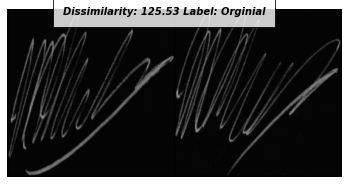

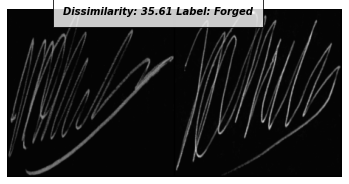

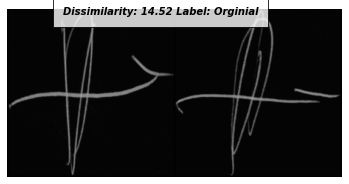

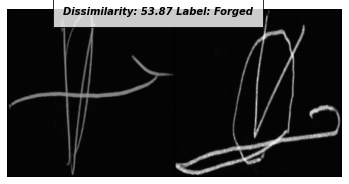

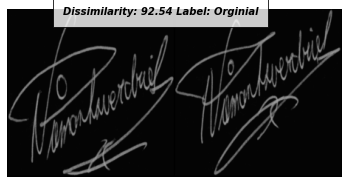

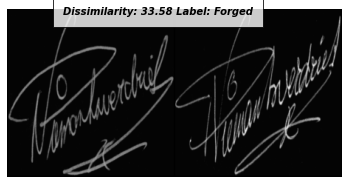

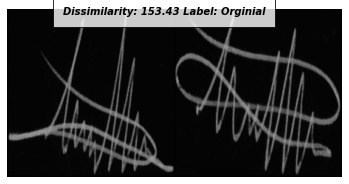

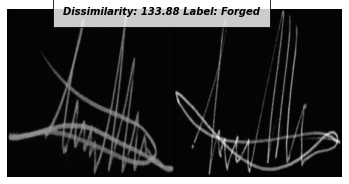

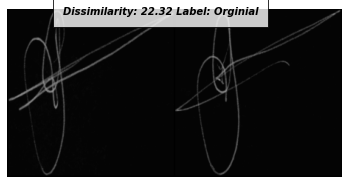

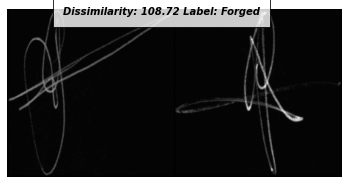

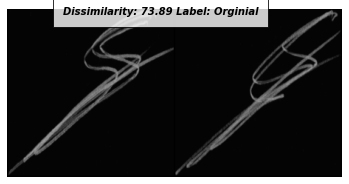

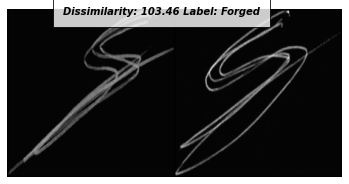

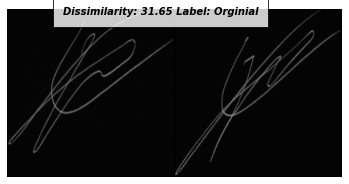

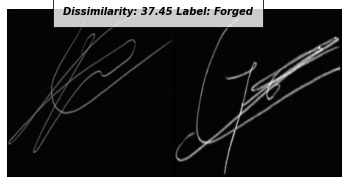

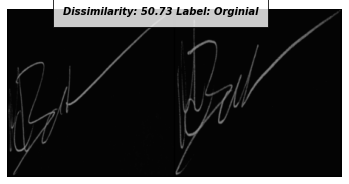

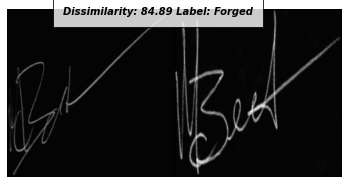

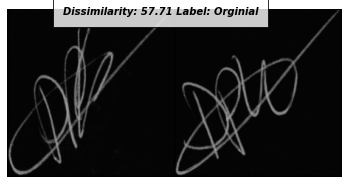

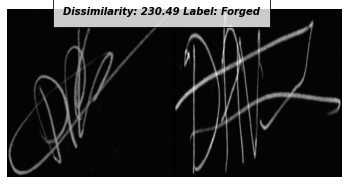

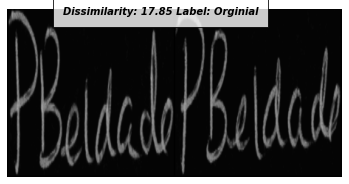

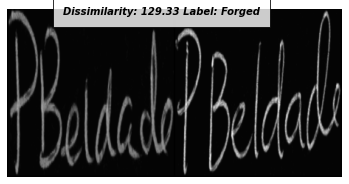

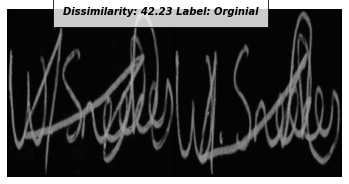

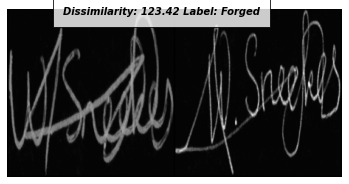

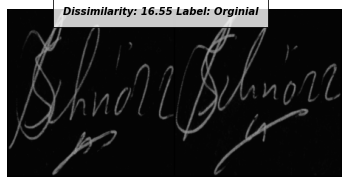

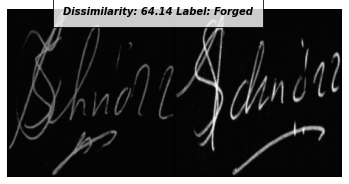

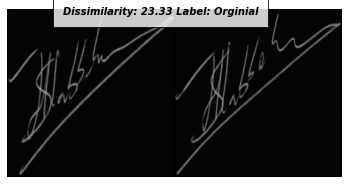

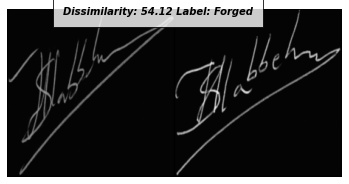

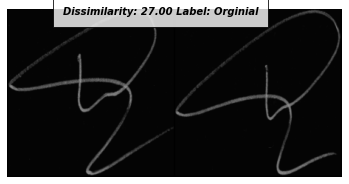

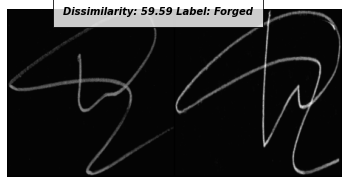

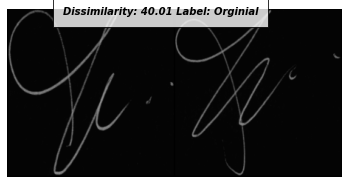

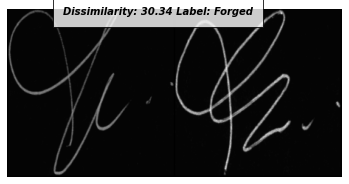

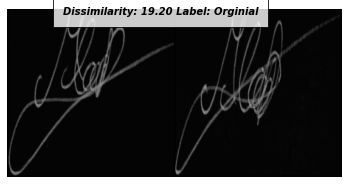

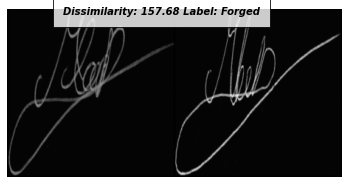

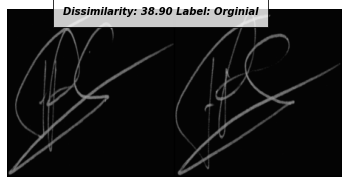

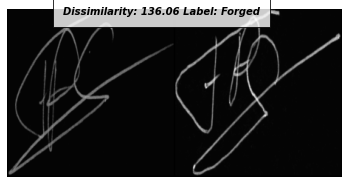

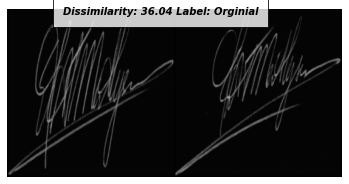

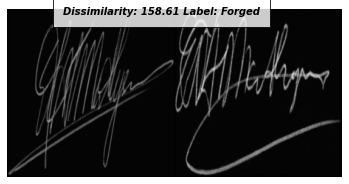

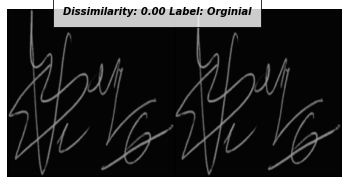

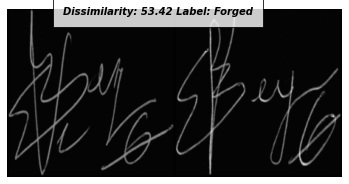

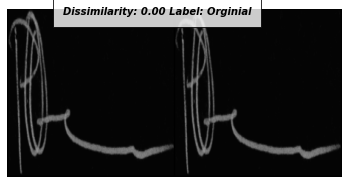

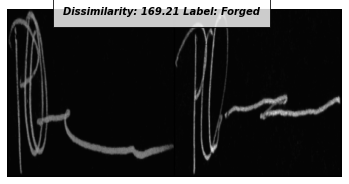

In [240]:
# Print the sample outputs to view its dissimilarity
counter=0
list_0 = torch.FloatTensor([[0]])
list_1 = torch.FloatTensor([[1]])
for i, data in enumerate(test_dataloader,0): 
  x0, x1 ,x3 = data
  concatenated1 = torch.cat((x0,x1),0)
  concatenated2 = torch.cat((x0,x3),0)
  output1, output2, output3 = net(x0.to(device), x1.to(device), x3.to(device))
  eucledian_distance1 = F.pairwise_distance(output1, output2)
  eucledian_distance2 = F.pairwise_distance(output1, output3)
  label="Orginial"
  imshow(torchvision.utils.make_grid(concatenated1),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance1.item(),label))
  label="Forged"
  imshow(torchvision.utils.make_grid(concatenated2),'Dissimilarity: {:.2f} Label: {}'.format(eucledian_distance2.item(),label))
  counter=counter+1
  if counter ==20:
     break